In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [2]:
def get_mixture_coef(output,KMIX):
    out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_pi, out_sigma, out_mu = tf.split(output,3,1)
    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    out_pi = tf.subtract(out_pi, max_pi)
    out_pi = tf.exp(out_pi)
    normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keep_dims=True))
    out_pi = tf.multiply(normalize_pi, out_pi)
    out_sigma = tf.exp(out_sigma)
    return out_pi, out_sigma, out_mu
def tf_normal(y, mu, sigma):
    oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
    result = tf.subtract(y, mu)
    result = tf.multiply(result,tf.reciprocal(sigma))
    result = -tf.square(result)/2
    return tf.multiply(tf.exp(result),tf.reciprocal(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)

def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) 
    rn = np.random.randn(NTEST, M)
    mu = 0
    std = 0
    idx = 0
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result


In [3]:
class MDN:
    def __init__(self):
        tf.reset_default_graph()
        NHIDDEN = 24
        STDEV = 0.5
        self.KMIX = 24
        NOUT = self.KMIX * 3 

        self.x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
        self.y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

        self.Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
        self.bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

        self.Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
        self.bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

        self.hidden_layer = tf.nn.tanh(tf.matmul(self.x, self.Wh) + self.bh)
        self.output = tf.matmul(self.hidden_layer,self.Wo) + self.bo
        self.out_pi, self.out_sigma, self.out_mu = get_mixture_coef(self.output,self.KMIX)
        
        self.lossfunc = get_lossfunc(self.out_pi, self.out_sigma, self.out_mu,self.y)
        self.train_op = tf.train.AdamOptimizer().minimize(self.lossfunc)
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.initialize_all_variables())
     
    def train(self, x_data,y_data,NEPOCH = 10000):
        
        self.loss = np.zeros(NEPOCH) # store the training progress here.
        for i in range(NEPOCH):
            self.sess.run(self.train_op,feed_dict={self.x: x_data, self.y: y_data})
            self.loss[i] = self.sess.run(self.lossfunc, feed_dict={self.x: x_data, self.y: y_data})
            if i%100==0:
                print("Epoch: %d loss: %4.4f"%(i,self.loss[i]))
            
    def test(self,x_test):
        self.out_pi_test, self.out_sigma_test, self.out_mu_test = self.sess.run(get_mixture_coef(self.output,self.KMIX), feed_dict={self.x: x_test})
        self.y_test = generate_ensemble(self.out_pi_test, self.out_mu_test, self.out_sigma_test)
        return self.y_test


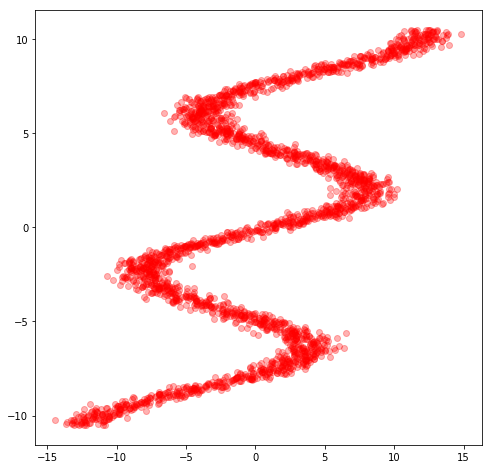

In [4]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+np.cos(0.75*y_data)+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [5]:
mdn = MDN()
mdn.train(x_data,y_data)
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1)
y_test = mdn.test(x_test)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0 loss: 4.2689
Epoch: 100 loss: 3.1475
Epoch: 200 loss: 2.9908
Epoch: 300 loss: 2.8505
Epoch: 400 loss: 2.2358
Epoch: 500 loss: 1.8319
Epoch: 600 loss: 1.6843
Epoch: 700 loss: 1.6303
Epoch: 800 loss: 1.6003
Epoch: 900 loss: 1.5792
Epoch: 1000 loss: 1.5601
Epoch: 1100 loss: 1.5283
Epoch: 1200 loss: 1.4888
Epoch: 1300 loss: 1.4674
Epoch: 1400 loss: 1.4499
Epoch: 1500 loss: 1.4379
Epoch: 1600 loss: 1.4266
Epoch: 1700 loss: 1.4182
Epoch: 1800 loss: 1.4102
Epoch: 1900 loss: 1.4008
Epoch: 2000 loss: 1.3908
Epoch: 2100 loss: 1.3871
Epoch: 2200 loss: 1.3741
Epoch: 2300 loss: 1

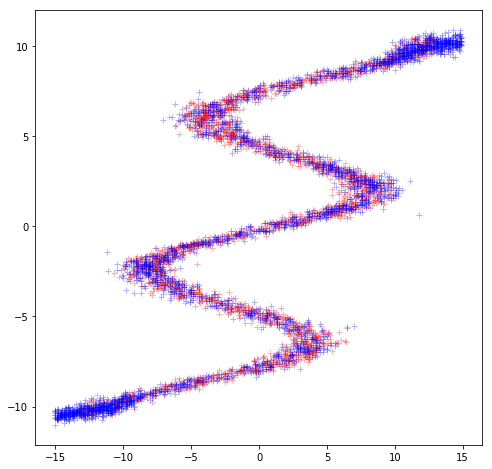

In [6]:
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'r+', x_test,y_test,'b+',alpha=0.3)
plt.show()